
Preprocessing complete. Data saved.
Rows in full dataset: 755891
Feature count (X): 46
Train samples: 604712 | Test samples: 151179

Summary statistics for log_duration:


count    755891.000000
mean          2.853277
std           0.901522
min           0.693147
25%           2.397895
50%           2.772589
75%           3.433987
max           7.273093
Name: log_duration, dtype: float64

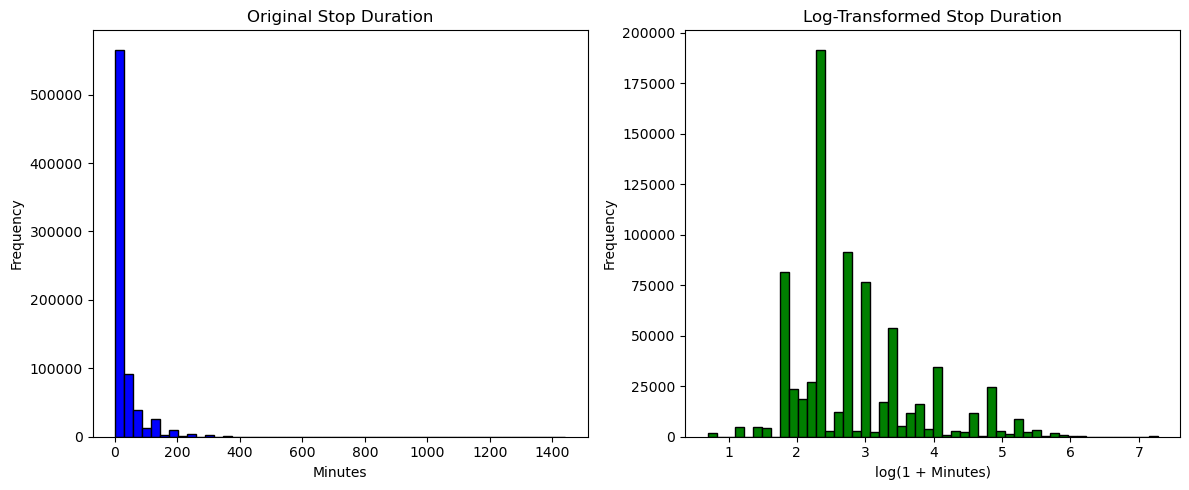


Preview of scaled features:


,exp_years,stop_in_response_to_cfs,officer_assignment_key,address_block,isschool
count,7.558910e+05,7.558910e+05,7.558910e+05,7.558910e+05,7.558910e+05
mean,-8.873665e-18,2.669620e-17,8.181820e-17,1.833013e-18,-9.315468e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-7.215936e-01,-3.322222e-01,-2.232804e-01,-2.457204e-02,-2.557266e-02
25%,-7.215936e-01,-3.322222e-01,-2.232804e-01,-1.877397e-02,-2.557266e-02
50%,-4.403257e-01,-3.322222e-01,-2.232804e-01,-1.027012e-02,-2.557266e-02
75%,5.441120e-01,-3.322222e-01,-2.232804e-01,-9.931924e-04,-2.557266e-02
max,6.169470e+00,3.010034e+00,5.015650e+00,3.865136e+02,3.910427e+01


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # <-- added for imputation

# Set path and load cleaned dataset
csv_directory = "C:/Users/harry/Documents/GitHub/SB/Springboard/Capstone 2/data"
ripa = pd.read_csv(os.path.join(csv_directory, "cleaned_ripa_dataset.csv"), low_memory=False)

# Feature Engineering: Derive stop_hour from time_stop
ripa["stop_hour"] = pd.to_datetime(ripa["time_stop"], format="%H:%M:%S", errors='coerce').dt.hour

# Handle Missing Values
categorical_cols = ["basis_for_search", "reason_for_stop"]
for col in categorical_cols:
    ripa[col] = ripa[col].fillna("Unknown")

if "perceived_age" in ripa.columns:
    ripa["perceived_age"] = ripa["perceived_age"].fillna(ripa["perceived_age"].median())

# Time-of-Day Binning
bins = [0, 6, 12, 18, 24]
labels = ['Late Night', 'Morning', 'Afternoon', 'Evening']
ripa['time_of_day'] = pd.cut(ripa['stop_hour'], bins=bins, labels=labels, right=False)

# Encode Categorical Features
categorical_features = [
    "race", "gender", "reason_for_stop", "basis_for_search", "time_of_day"
]
ripa = pd.get_dummies(ripa, columns=categorical_features, drop_first=True)

# Target Transformation (due to right skew)
if "stopduration" not in ripa.columns:
    raise ValueError("Missing required target column: 'stopduration'")

ripa['log_duration'] = np.log1p(ripa['stopduration'])

# Feature Scaling (with Imputation)
non_numeric_cols = ripa.select_dtypes(include='object').columns.tolist()
features_to_scale = ripa.drop(columns=[
    "stopduration", "log_duration", "stop_id", "pid"] + non_numeric_cols,
    errors='ignore'
)

# Impute missing values before scaling
imputer = SimpleImputer(strategy='mean')
features_to_scale_imputed = imputer.fit_transform(features_to_scale)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale_imputed)
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

scaled_df["stopduration"] = ripa["stopduration"].values
scaled_df["log_duration"] = ripa["log_duration"].values

# Train/Test Split
X = scaled_df.drop(columns=["stopduration", "log_duration"])
y = scaled_df["stopduration"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Save Preprocessed Dataset
scaled_df.to_csv(os.path.join(csv_directory, "ripa_preprocessed.csv"), index=False)
X_train.to_csv(os.path.join(csv_directory, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(csv_directory, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(csv_directory, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(csv_directory, "y_test.csv"), index=False)

print("\nPreprocessing complete. Data saved.")
print(f"Rows in full dataset: {scaled_df.shape[0]}")
print(f"Feature count (X): {X.shape[1]}")
print(f"Train samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")

# Show summary statistics
print("\nSummary statistics for log_duration:")
display(scaled_df['log_duration'].describe())

# Plot distribution of raw and log-transformed stop durations
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(ripa['stopduration'], bins=50, color='blue', edgecolor='black')
axs[0].set_title('Original Stop Duration')
axs[0].set_xlabel('Minutes')
axs[0].set_ylabel('Frequency')

axs[1].hist(ripa['log_duration'], bins=50, color='green', edgecolor='black')
axs[1].set_title('Log-Transformed Stop Duration')
axs[1].set_xlabel('log(1 + Minutes)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check feature distribution 
print("\nPreview of scaled features:")
display(scaled_df.iloc[:, :5].describe())